In [ ]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torchsummary import summary
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import time
import tqdm

In [ ]:
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
def exec_time(f):
  def wrapper(*args, **kargs):
    before = time.time()
    res = f(*args, **kargs)
    after = time.time()
    print('Execution time: {:.2f}s'.format(after-before))
    return res
  return wrapper

## Download dataset

In [ ]:
!gdown --id 1--m_DXJOH-Yka9pmIB_tTyvniYSE_3P2

Downloading...
From: https://drive.google.com/uc?id=1--m_DXJOH-Yka9pmIB_tTyvniYSE_3P2
To: /content/IntelImageClassification.zip
100% 363M/363M [00:03<00:00, 115MB/s] 


Unzip file, construct folder

In [ ]:
!unzip -q IntelImageClassification.zip

In [ ]:
!mkdir dataset && mv seg_train/seg_train dataset/train && mv seg_test/seg_test dataset/test

Load data

In [ ]:
transform = T.Compose([
    T.Resize((142, 142)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
trainset = torchvision.datasets.ImageFolder(root='dataset/train', transform=transform)
train_loader = data.DataLoader(dataset=trainset, batch_size=256, shuffle=True)

testset = torchvision.datasets.ImageFolder(root='dataset/test', transform=transform)
test_loader = data.DataLoader(dataset=testset, batch_size=256, shuffle=False)

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images in dl:
        show_images(images, nmax)
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


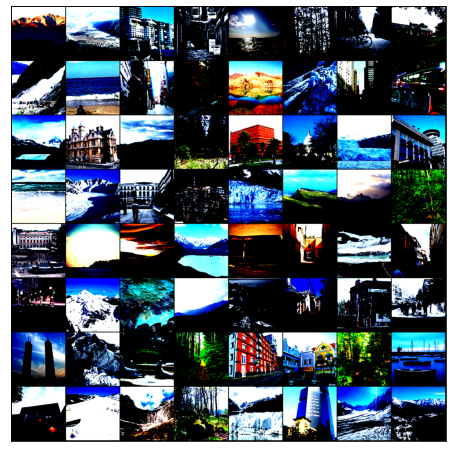

In [ ]:
show_batch(next(iter(train_loader)))

In [ ]:
# model = torchvision.models.alexnet(pretrained=True)
model = torchvision.models.vgg16(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
model.classifier = nn.Sequential(*list(model.classifier.children())[:-5])
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
model.to(device)
model.eval()

@exec_time
def extract_feature(model, data_loader):
  features = []
  labels = []

  with torch.no_grad():
    for img, target in data_loader:
      img = img.to(device)
      feat = model(img).cpu().detach().numpy()
      features.append(feat)
      labels.append(target)

  features = np.vstack(features)
  labels = np.concatenate(labels)
  return features, labels

X_train, y_train = extract_feature(model, train_loader)
print(X_train.shape, y_train.shape)
X_test, y_test = extract_feature(model, test_loader)
print(X_test.shape, y_test.shape)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Execution time: 105.49s
(14034, 4096) (14034,)
Execution time: 23.38s
(3000, 4096) (3000,)


In [ ]:
from sklearn.svm import SVC

@exec_time
def train_svc(X, y, kernel='rbf'):
  model = SVC(kernel=kernel, random_state=0)
  model.fit(X, y)
  return model

model = train_svc(X_train, y_train)

Execution time: 291.01s


In [ ]:
@exec_time
def predict(model, X):
  return model.predict(X)

y_pred = predict(model, X_test)

Execution time: 80.85s


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, accuracy_score
# print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.91      0.91       437
           1       0.99      0.99      0.99       474
           2       0.88      0.84      0.86       553
           3       0.87      0.87      0.87       525
           4       0.93      0.97      0.95       510
           5       0.92      0.94      0.93       501

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



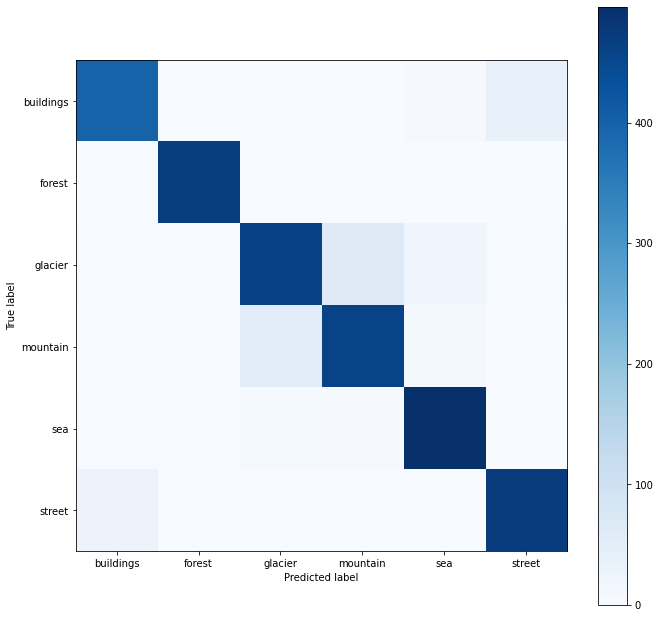

<Figure size 792x792 with 0 Axes>

In [ ]:
cm = confusion_matrix(y_test, y_pred)
display_labels = trainset.classes

figsize=(11, 11)
fig, ax = plt.subplots(figsize=figsize)

disp = ConfusionMatrixDisplay(cm, display_labels)
disp = disp.plot(include_values=False,
                 cmap='Blues', ax=ax)
disp.figure_ = plt.figure(figsize=figsize)

plt.show()

# Fine-tuning

In [ ]:
# model = torchvision.models.alexnet(pretrained=True)
model = torchvision.models.alexnet(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
model.classifier = nn.Sequential(*list(model.classifier.children())[:-1], nn.Linear(in_features=4096, out_features=6))

In [ ]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# Freeze all layer in NN, except for the last one
for param in model.parameters():
  param.requires_grad = True

for param in model.classifier[:].parameters():
  param.requires_grad = True

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.000001)
loss = nn.CrossEntropyLoss()

epochs = 10

model.to(device)
model.train()

running_loss = 0
for epoch in range(epochs):
  for i, batch in tqdm.tqdm(list(enumerate(train_loader))):
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    l = loss(outputs, labels)
    l.backward()
    optimizer.step()

    running_loss += l.item()
    if i % 10 == 9:
      print('[%d, %5d] loss: %.3f' %
        (epoch + 1, i + 1, running_loss / 10))
      running_loss = 0.0

 20%|██        | 11/55 [00:02<00:08,  4.98it/s]

[1,    10] loss: 0.087


 38%|███▊      | 21/55 [00:04<00:06,  5.09it/s]

[1,    20] loss: 0.098


 56%|█████▋    | 31/55 [00:06<00:04,  5.10it/s]

[1,    30] loss: 0.096


 75%|███████▍  | 41/55 [00:08<00:02,  5.10it/s]

[1,    40] loss: 0.093


 93%|█████████▎| 51/55 [00:10<00:00,  5.10it/s]

[1,    50] loss: 0.083


 20%|██        | 11/55 [00:02<00:08,  4.94it/s]

[2,    10] loss: 0.145


 38%|███▊      | 21/55 [00:04<00:06,  5.07it/s]

[2,    20] loss: 0.102


 56%|█████▋    | 31/55 [00:06<00:04,  5.06it/s]

[2,    30] loss: 0.112


 75%|███████▍  | 41/55 [00:08<00:02,  5.08it/s]

[2,    40] loss: 0.097


 93%|█████████▎| 51/55 [00:10<00:00,  5.09it/s]

[2,    50] loss: 0.102


 20%|██        | 11/55 [00:02<00:08,  4.92it/s]

[3,    10] loss: 0.124


 38%|███▊      | 21/55 [00:04<00:06,  5.11it/s]

[3,    20] loss: 0.091


 56%|█████▋    | 31/55 [00:06<00:04,  5.09it/s]

[3,    30] loss: 0.090


 75%|███████▍  | 41/55 [00:08<00:02,  5.07it/s]

[3,    40] loss: 0.099


 93%|█████████▎| 51/55 [00:10<00:00,  5.14it/s]

[3,    50] loss: 0.098


 20%|██        | 11/55 [00:02<00:08,  5.07it/s]

[4,    10] loss: 0.131


 38%|███▊      | 21/55 [00:04<00:06,  5.09it/s]

[4,    20] loss: 0.093


 56%|█████▋    | 31/55 [00:06<00:04,  5.09it/s]

[4,    30] loss: 0.095


 75%|███████▍  | 41/55 [00:08<00:02,  5.11it/s]

[4,    40] loss: 0.089


 93%|█████████▎| 51/55 [00:10<00:00,  5.07it/s]

[4,    50] loss: 0.101


 18%|█▊        | 10/55 [00:02<00:09,  4.89it/s]

[5,    10] loss: 0.134


 38%|███▊      | 21/55 [00:04<00:06,  5.07it/s]

[5,    20] loss: 0.094


 56%|█████▋    | 31/55 [00:06<00:04,  5.08it/s]

[5,    30] loss: 0.095


 75%|███████▍  | 41/55 [00:08<00:02,  5.07it/s]

[5,    40] loss: 0.080


 93%|█████████▎| 51/55 [00:10<00:00,  5.06it/s]

[5,    50] loss: 0.092


 18%|█▊        | 10/55 [00:02<00:09,  4.85it/s]

[6,    10] loss: 0.136


 36%|███▋      | 20/55 [00:04<00:06,  5.07it/s]

[6,    20] loss: 0.090


 56%|█████▋    | 31/55 [00:06<00:04,  5.06it/s]

[6,    30] loss: 0.085


 75%|███████▍  | 41/55 [00:08<00:02,  5.10it/s]

[6,    40] loss: 0.103


 93%|█████████▎| 51/55 [00:10<00:00,  5.04it/s]

[6,    50] loss: 0.092


 20%|██        | 11/55 [00:02<00:09,  4.88it/s]

[7,    10] loss: 0.141


 38%|███▊      | 21/55 [00:04<00:06,  5.03it/s]

[7,    20] loss: 0.078


 56%|█████▋    | 31/55 [00:06<00:04,  5.10it/s]

[7,    30] loss: 0.093


 75%|███████▍  | 41/55 [00:08<00:02,  5.07it/s]

[7,    40] loss: 0.086


 93%|█████████▎| 51/55 [00:10<00:00,  5.02it/s]

[7,    50] loss: 0.088


 18%|█▊        | 10/55 [00:02<00:09,  5.00it/s]

[8,    10] loss: 0.133


 38%|███▊      | 21/55 [00:04<00:06,  5.12it/s]

[8,    20] loss: 0.087


 56%|█████▋    | 31/55 [00:06<00:04,  5.02it/s]

[8,    30] loss: 0.091


 75%|███████▍  | 41/55 [00:08<00:02,  5.02it/s]

[8,    40] loss: 0.096


 93%|█████████▎| 51/55 [00:10<00:00,  5.08it/s]

[8,    50] loss: 0.083


 18%|█▊        | 10/55 [00:02<00:09,  4.85it/s]

[9,    10] loss: 0.131


 38%|███▊      | 21/55 [00:04<00:06,  5.05it/s]

[9,    20] loss: 0.085


 56%|█████▋    | 31/55 [00:06<00:04,  5.04it/s]

[9,    30] loss: 0.089


 75%|███████▍  | 41/55 [00:08<00:02,  5.03it/s]

[9,    40] loss: 0.086


 93%|█████████▎| 51/55 [00:10<00:00,  5.05it/s]

[9,    50] loss: 0.083


 20%|██        | 11/55 [00:02<00:08,  4.90it/s]

[10,    10] loss: 0.134


 38%|███▊      | 21/55 [00:04<00:06,  5.05it/s]

[10,    20] loss: 0.085


 56%|█████▋    | 31/55 [00:06<00:04,  5.02it/s]

[10,    30] loss: 0.093


 75%|███████▍  | 41/55 [00:08<00:02,  5.05it/s]

[10,    40] loss: 0.089


 93%|█████████▎| 51/55 [00:10<00:00,  5.09it/s]

[10,    50] loss: 0.080


100%|██████████| 55/55 [00:11<00:00,  4.98it/s]


In [ ]:
y_test = []
model.eval()
with torch.no_grad():
  y_preds = []
  for data in test_loader:
    inputs, labels = data
    inputs = inputs.to(device)
    y_test.append(labels)

    outputs = model(inputs)
    _, y_pred = torch.max(outputs.data, 1)
    y_preds.append(y_pred.cpu().detach().numpy())

  y_preds = np.concatenate(y_preds)
  y_test = np.concatenate(y_test)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, accuracy_score
accuracy_score(y_test, y_preds)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89       437
           1       0.98      1.00      0.99       474
           2       0.88      0.86      0.87       553
           3       0.86      0.87      0.86       525
           4       0.94      0.94      0.94       510
           5       0.89      0.94      0.91       501

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



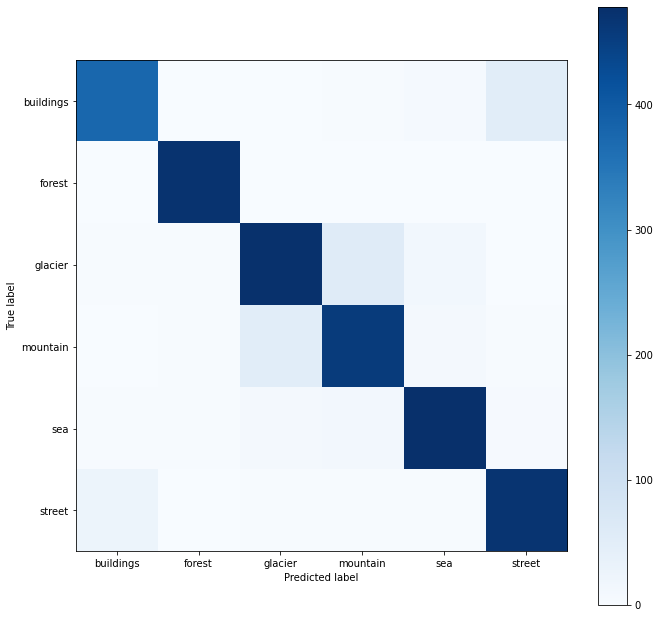

<Figure size 792x792 with 0 Axes>

In [ ]:
cm = confusion_matrix(y_test, y_preds)
display_labels = trainset.classes

figsize=(11, 11)
fig, ax = plt.subplots(figsize=figsize)

disp = ConfusionMatrixDisplay(cm, display_labels)
disp = disp.plot(include_values=False,
                 cmap='Blues', ax=ax)
disp.figure_ = plt.figure(figsize=figsize)

plt.show()

## Using SIFT for feature extraction and train with SVM

In [ ]:
!pip install opencv-contrib-python==4.4.0.44

In [ ]:
import cv2
sift = cv2.SIFT_create()

In [ ]:
def bag_of_features(features, centres, k = 500):
    vec = np.zeros((1, k))
    for i in range(features.shape[0]):
        feat = features[i]
        diff = np.tile(feat, (k, 1)) - centres
        dist = pow(((pow(diff, 2)).sum(axis = 1)), 0.5)
        idx_dist = dist.argsort()
        idx = idx_dist[0]
        vec[0][idx] += 1
    return vec

In [ ]:
transform = T.Compose([
      T.Resize((142, 142)),
      T.ToTensor()
])
train = torchvision.datasets.ImageFolder(root='dataset/train', transform=transform)
test = torchvision.datasets.ImageFolder(root='dataset/test', transform=transform)

In [ ]:
@exec_time
def calculate_feature(train, sift):
  features = []
  for img, target in train:
    img = np.array(img)
    img = np.transpose(img, (1, 2, 0))
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = (255 * gray).astype('uint8')
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    if descriptors is None:
      continue
    features.append(descriptors)
  features = np.vstack(features)
  return features

features = calculate_feature(train, sift)

Execution time: 209.71s


In [ ]:
n_clusters = 250

@exec_time
def train_kmean(features, k=200):
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.1)
  flags = cv2.KMEANS_RANDOM_CENTERS
  compactness, labels, centres = cv2.kmeans(features, k, None, criteria, 10, flags)
  return centres

centres = train_kmean(features, k=n_clusters)

Execution time: 1860.81s


In [ ]:
@exec_time
def extract_feature(dataset, centres, k=200):
  X = []
  y = []
  for img, target in dataset:
    img = np.array(img)
    img = np.transpose(img, (1, 2, 0))
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = (255 * gray).astype('uint8')
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    if descriptors is None:
      continue
    feat = bag_of_features(descriptors, centres, k)
    X.append(feat)
    y.append(target)
  X = np.vstack(X)
  y = np.array(y)
  return X, y

X_train, y_train = extract_feature(train, centres, k=n_clusters)
X_test, y_test = extract_feature(test, centres, k=n_clusters)

Execution time: 458.32s
Execution time: 97.23s


In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
from sklearn.svm import SVC

@exec_time
def train_svc(X, y, kernel='linear'):
  model = SVC(kernel=kernel, random_state=0)
  model.fit(X, y)
  return model

model = train_svc(X_train, y_train)

Execution time: 184.25s


In [ ]:
@exec_time
def predict(model, X):
  y = model.predict(X)
  return y

y_pred = predict(model, X_test)

Execution time: 8.10s


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, accuracy_score
accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.64      0.64       437
           1       0.83      0.84      0.83       474
           2       0.51      0.50      0.50       553
           3       0.48      0.53      0.51       523
           4       0.55      0.53      0.54       508
           5       0.61      0.56      0.58       501

    accuracy                           0.60      2996
   macro avg       0.60      0.60      0.60      2996
weighted avg       0.60      0.60      0.60      2996



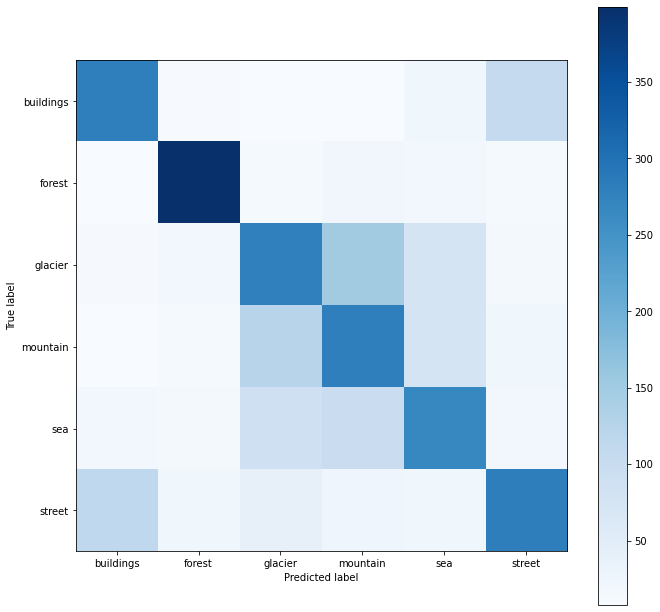

<Figure size 792x792 with 0 Axes>

In [ ]:
cm = confusion_matrix(y_test, y_pred)
display_labels = train.classes

figsize=(11, 11)
fig, ax = plt.subplots(figsize=figsize)

disp = ConfusionMatrixDisplay(cm, display_labels)
disp = disp.plot(include_values=False,
                 cmap='Blues', ax=ax)
disp.figure_ = plt.figure(figsize=figsize)

plt.show()